# Fundamental Matrix and RANSAC

In this exercise, you will learn:
- how to estimate the fundamental matrix $F$ that geometrically relates two views of the same scene
- how to make your estimation more robust to outliers and noise which is important in practice

For some functions we already provide some draft implementation that you just need to complete. This is supposed to help you identifying the next steps. Still, if it does not fit your idea you may ignore it.

## 1. Setup

Load all libraries and both views that we will work with. In this exercise you are given two views again and matching key points which we extracted in advance.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal

In [49]:
from matplotlib.patches import ConnectionPatch

# use this function to visualize the matches
def plot_matches(img1, img2, keypoints1, keypoints2):
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    
    # draw matches
    for kp1, kp2 in zip(keypoints1, keypoints2):
        c = np.random.rand(3)
        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color=c)
        fig.add_artist(con)
        axes[0].plot(*kp1, color=c, marker='x')
        axes[1].plot(*kp2, color=c, marker='x')
    
    plt.show()

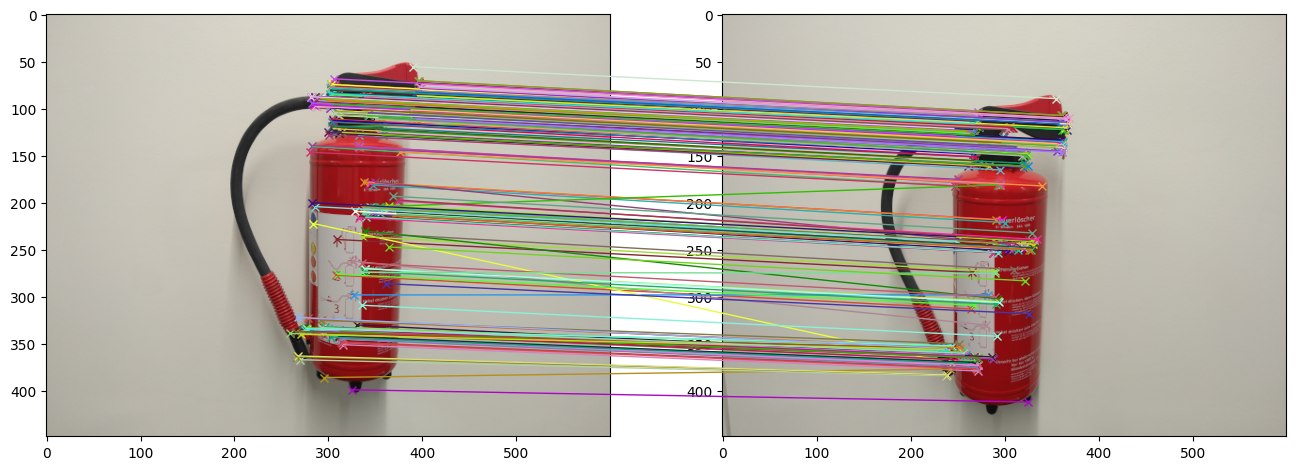

In [50]:
# Load images
view1 = np.array(Image.open("data/exercise3/view1.png")) / 255
view2 = np.array(Image.open("data/exercise3/view2.png")) / 255

# Load matching keypoints
with np.load("data/exercise4/keypoints.npz") as data:
    keypoints1 = data["view1"]
    keypoints2 = data["view2"]
    
plot_matches(view1, view2, keypoints1, keypoints2)

### 4.1. Fundamental Matrix
We begin with computing the fundamental matrix $F$ which defines the epipolar constraints for two views of two uncalibrated cameras. It determines the lines corresponding points can lie on. If we have a total of eight pairs of corresponding points this matrix can be estimated using the 8-point algorithm discussed in the lecture, see slide deck 

Your task now is to use eight point matches and compute the fundamental matrix $F$ by performing a direct linear transform and then decompose the resulting matrix using SVD. You might want to look at the slides again.

Hint: Use `numpy.linalg.svd` for singular value decomposition and do not forget to rescale the point coordinates to obtain stable results (this is termed 'conditioning' on the slides).

In [51]:
def find_fundamental_svd(kps1, kps2):
    """
    Estimate fundamental matrix using SVD
    :param kps1: keypoints extracted from view1 in homogeneous coordinates
    :param kps2: keypoints extracted from view2 in homogeneous coordinates
    :return: Fundamental matrix F
    """
    def condition_points(points):
        """
        Conditions points by normalizing them to have zero mean and average distance sqrt(2) from the origin.
        :param points: Nx3 array of points in homogeneous coordinates
        :return: Conditioned points and the transformation matrix T
        """
        mean = np.mean(points[:, :2], axis=0)
        std = np.std(points[:, :2])

        scale = np.sqrt(2) / std
        T = np.array([
            [scale, 0, -scale * mean[0]],
            [0, scale, -scale * mean[1]],
            [0, 0, 1]
        ])

        points_conditioned = (T @ points.T).T
        return points_conditioned, T

    def enforce_rank_2(F):
        """Enforce the rank-2 constraint on the fundamental matrix."""
        U, S, Vt = np.linalg.svd(F)
        S[2] = 0  # Set the smallest singular value to 0
        return U @ np.diag(S) @ Vt

    # Condition the points
    kps1_conditioned, T1 = condition_points(kps1)
    kps2_conditioned, T2 = condition_points(kps2)

    # Collect equations
    A = np.array([
        [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]
        for (x1, y1, _), (x2, y2, _) in zip(kps1_conditioned, kps2_conditioned)
    ])

    # Solve for the fundamental matrix using SVD
    _, _, Vt = np.linalg.svd(A)
    F_conditioned = Vt[-1].reshape(3, 3)

    # Enforce rank-2 constraint
    F_conditioned = enforce_rank_2(F_conditioned)

    # Uncondition the fundamental matrix
    F = T2.T @ F_conditioned @ T1

    return F

In [52]:
kps1 = np.hstack((keypoints1, np.ones((keypoints1.shape[0], 1))))
kps2 = np.hstack((keypoints2, np.ones((keypoints2.shape[0], 1))))

# Compute the fundamental matrix
F = find_fundamental_svd(kps1, kps2)


Check your code by visualizing the epipolar lines of you key points. We provide the function for this below. What do you see?

In [53]:
def visualize_epipolar_lines(img1, img2, keypoints1, keypoints2, F):
    """
    :params img1: view 1
    :params img2: view 2
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :params F: the fundamental matrix
    """
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    res = img1.shape[:2]
    
    for color_index, (kp1, kp2) in enumerate(zip(keypoints1, keypoints2)):
        c = np.random.rand(3)
        
        # plot points
        axes[0].plot(kp1[0], kp1[1], color=c, marker='o',markersize=5)
        axes[1].plot(kp2[0], kp2[1], color=c, marker='o',markersize=5)
        
        # compute epi lines
        epi_line_2 = kp1[None,...] @ F
        epi_line_1 = F @ kp2[None,...].T
        
        # plot lines
        for i, line in enumerate([epi_line_1, epi_line_2]):
            line = line.flatten()
            fn = lambda x: (line[0]*x + line[2]) / -line[1]
            xs = np.arange(res[1])
            axes[i].plot(xs, fn(xs), c=c)
    
    axes[0].set_ylim((res[0],0))
    axes[1].set_ylim((res[0],0))
    
    plt.show()

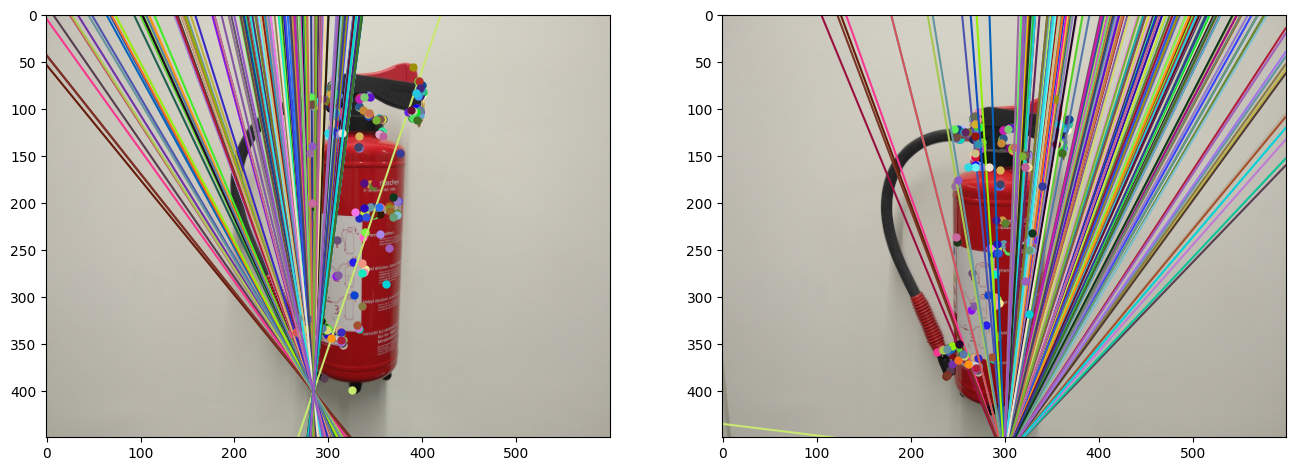

In [54]:
# Visualize the epipolar lines
visualize_epipolar_lines(view1, view2, kps1, kps2, F)

Also, compute the algebraic error, i.e. how well is the epipolar contraint $x_0^TFx_1=0$ met.
Furthermore, calculate the geometric error, i.e. are the points far away from the epipolar lines.
What do the algebraic and geometric error values show you?

In [55]:
def algebraic_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        error = np.abs(kp1[None,...] @ F @ kp2[None,...].T)
        errors.append(error.item())
    return errors

def geometric_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        x1F = kp1[None,...] @ F
        Fx2 = F @ kp2[None,...].T
        x1Fx2 = x1F @ kp2[None,...].T
        
        part1 = 1/(x1F.flatten()[0] ** 2 + x1F.flatten()[1] ** 2)
        part2 = 1/(Fx2.flatten()[0] ** 2 + Fx2.flatten()[1] ** 2)
        
        error = np.sqrt(x1Fx2 ** 2 * (part1 + part2))
        errors.append(error.item())
    return errors

In [56]:
# Compute algebraic and geometric errors
algebraic_errs = algebraic_error(kps1, kps2, F)
geometric_errs = geometric_error(kps1, kps2, F)

print(f"Average Algebraic Error: {np.mean(algebraic_errs):.6f}")
print(f"Average Geometric Error: {np.mean(geometric_errs):.6f}")

Average Algebraic Error: 0.704387
Average Geometric Error: 96.868010


### 4.2 Robust estimation using RANSAC
As some of the point matches suffer from noise or are even incorrect. The risk of obtaining an incorrect fundamental matrix by relying just on eight points is high. Hence, we are looking for a more robust version of estimating $F$. To do this, the RANSAC algorithm was introduced in the lecture. Your final task is to complete the implementation for fundamental matrix estimation by using RANSAC. You can compare the errors and epipolar lines of a robustly estimated $F$ with the one from the previous task.

In [57]:
def find_fundamental_ransac(keypoints1, keypoints2, num_samples=8, threshold=1.0, iterations=1000, min_inliers=30):
    """
    Estimate the fundamental matrix robustly using RANSAC.
    :param keypoints1: keypoints from view 1 (homogeneous coordinates)
    :param keypoints2: keypoints from view 2 (homogeneous coordinates)
    :param num_samples: number of samples to draw in each RANSAC iteration
    :param threshold: error threshold to determine inliers
    :param iterations: number of RANSAC iterations
    :param min_inliers: minimum number of inliers to accept a model
    :return: Best fundamental matrix and inlier mask
    """
    def sampson_distance(F, kp1, kp2):
        """
        Compute the Sampson distance to measure the geometric error.
        """
        Fx1 = F @ kp1.T
        FTx2 = F.T @ kp2.T
        numerator = (kp2 @ F @ kp1.T) ** 2
        denominator = Fx1[0]**2 + Fx1[1]**2 + FTx2[0]**2 + FTx2[1]**2
        return numerator / denominator

    best_F = None
    best_inliers = []
    
    num_points = keypoints1.shape[0]

    for i in range(iterations):
        # Randomly sample 8 points
        indices = np.random.choice(num_points, num_samples, replace=False)
        sample_kp1 = keypoints1[indices]
        sample_kp2 = keypoints2[indices]

        # Estimate F using the sampled points
        F = find_fundamental_svd(sample_kp1, sample_kp2)

        # Calculate geometric error (Sampson distance) for all points
        errors = np.array([sampson_distance(F, kp1, kp2) 
                           for kp1, kp2 in zip(keypoints1, keypoints2)])

        # Find inliers based on the threshold
        inliers = errors < threshold
        num_inliers = np.sum(inliers)

        # Update the best model if the current one is better
        if num_inliers > len(best_inliers) and num_inliers > min_inliers:
            best_F = F
            best_inliers = inliers

    if best_F is None:
        raise ValueError("RANSAC failed to find a good fundamental matrix.")

    return best_F, best_inliers

In [58]:
F, inliers = find_fundamental_ransac(kps1, kps2)

Now visualize again the epipolar lines and compute the errors. What has changed?

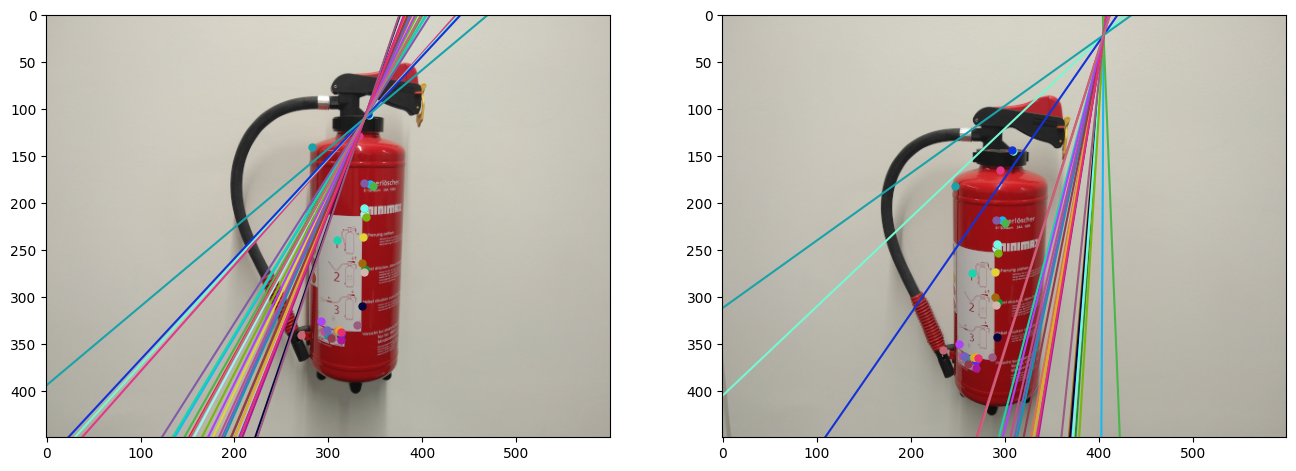

Average Algebraic Error (RANSAC): 0.987512
Average Geometric Error (RANSAC): 91.861885
Number of Inliers: 31


In [59]:
# Filter inlier keypoints
inlier_kps1 = kps1[inliers]
inlier_kps2 = kps2[inliers]

# Visualize the robust epipolar lines
visualize_epipolar_lines(view1, view2, inlier_kps1, inlier_kps2, F)

# Compute and print the errors
algebraic_errs_ransac = algebraic_error(inlier_kps1, inlier_kps2, F)
geometric_errs_ransac = geometric_error(inlier_kps1, inlier_kps2, F)

print(f"Average Algebraic Error (RANSAC): {np.mean(algebraic_errs_ransac):.6f}")
print(f"Average Geometric Error (RANSAC): {np.mean(geometric_errs_ransac):.6f}")
print(f"Number of Inliers: {np.sum(inliers)}")